# <font color = 'pickle'>**Finetuning with RoBERTa base model**
- I will be following a standard model training plan using the huggingface library and WANDB to track my experiment.
  - The idea is to use the base RoBERTa model to compare how well a pre-trained model does in comparison to the last model I trained (RNN)
  - There are some class imbalances so I want to make sure I account for that within my model.

**Training Plan**
- Set the Environment
- Load the dataset
- maniupulate the splits of the dataset
- Load the pretrained BERT tokenizer.
- Train the model
  - Download the model
  - Download and modify the model's config file.
  - Compute the metric function (ensuring we account for multilabel)(BCE)
  - Training Args
  - Instantiate the trainer
  - Setup WANDB
  - Training and Validation
- Model inference/ attach predictions to the Kaggle leaderboard and assess performance.


# <font color = 'pickle'>**Setting up the environment**

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
        # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'
        # Installing the latest torchinfo library
    !pip install torchtext -qq
    !pip install transformers evaluate wandb datasets accelerate  -U -qq

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00


<font color = 'pickle'>***Loading Libraries***

In [ ]:
# Standard Datascience libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from pathlib import Path
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import joblib

# Huggingface, wandb, torch etc
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoConfig, pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import torch
import ast


In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('HF login not unsuccessful - Missing token')


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Login Successful


In [ ]:
# Wandb here

if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
# Designating paths for saving and loading
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/ROBERTA_BASE'


# <font color = 'pickle'>**Loading the datasets**

- A split of this data was already made in a previous notebook, I will be loading the files here and manipulating them to a df




In [ ]:
# Loading the original data for understanding
train_valid_df = pd.read_csv(data_folder/'train.csv') # Data before my split in RNN model ipynb
train_valid_df.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
5,2017-22190,No but that's so cute. Atsu was probably shy a...,0,0,0,0,1,0,0,0,0,0,0
6,2017-20221,Do you think humans have the sense for recogni...,0,1,0,0,0,0,0,1,0,0,0
7,2017-22180,Rooneys fucking untouchable isn't he? Been fuc...,1,0,1,0,0,0,0,0,0,0,0
8,2017-41344,it's pretty depressing when u hit pan on ur fa...,0,0,1,0,0,0,0,0,1,0,0
9,2017-20759,@BossUpJaee but your pussy was weak from what ...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]


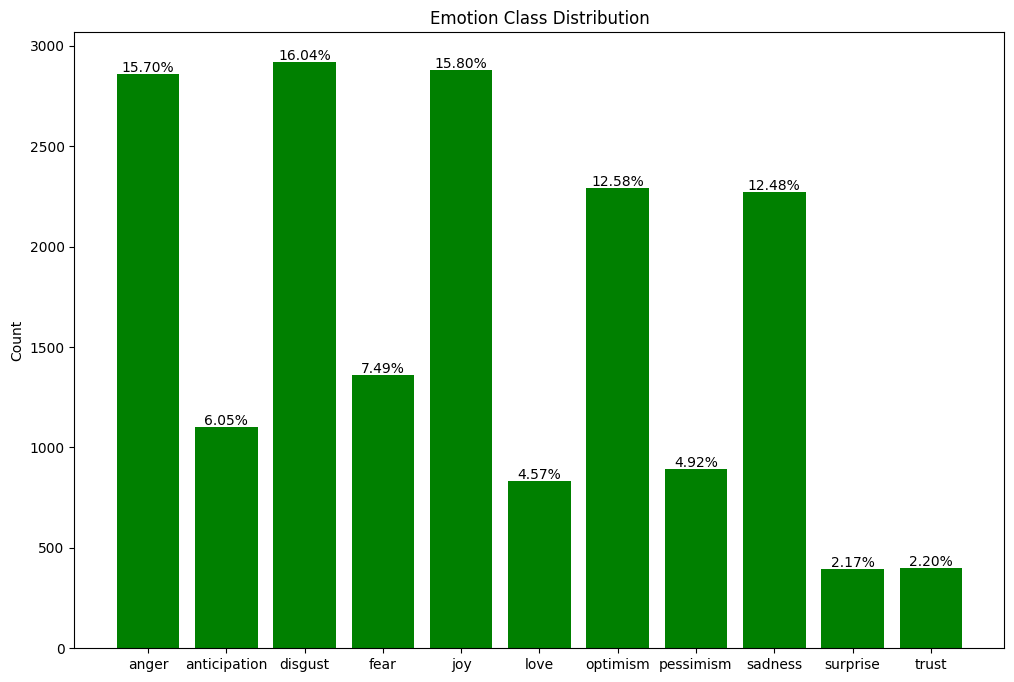

In [ ]:
# plotting of class distribution
label_counts = train_val_labels.sum()

# Total label counts
total_counts = label_counts.sum()

# percentage calculations
percentages = (label_counts/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'green')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()


## <font color='pickle'>**Accounting for the class imbalance**</font>

- I don't want to leak any information about the validation set to the training process, so I will be using some weights I calculated after splitting the data into training and validation sets.
- Here is what the code looked like:

```python
class_counts = np.sum(y_train, axis=0)

total_samples = y_train.shape[0]

class_weights = total_samples / (len(class_counts) * class_counts)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(class_counts)
print(total_samples)
print(class_weights)


**Actual Files I will be using for Training/Inference**

In [ ]:
# Train
train_ds = joblib.load(data_folder/'X_train_cleaned.pkl')
# Val
val_ds = joblib.load(data_folder/'X_val_cleaned.pkl')
# Test
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

# Class weights
class_weights = joblib.load(data_folder/'class_weights.pkl')

In [ ]:
# Viewing train

train_df = pd.DataFrame(train_ds).T
train_df.rename(columns ={0:'text', 1:'label'}, inplace = True)
print(train_df.head())
print('-'*30)
print(train_df.shape)



                                                text  \
0  @KMunie7 @KaranEsch Helluva lot more animated ...   
1  Despite my sharing O'Neill's article, what sad...   
2  @mtailor “20% Better Than a Tailor”? Least a t...   
3  How on earth can the projection of all that is...   
4  Patti seems so sad. She stamped and ran behind...   

                               label  
0  [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]  
1  [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]  
2  [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]  
3  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]  
------------------------------
(5406, 2)


In [ ]:
# View validation

val_df = pd.DataFrame(val_ds).T
val_df.rename(columns ={0:'text', 1:'label'}, inplace = True)
print(val_df.head())
print('-'*30)
print(val_df.shape)



                                                text  \
0  I'm due for a big change! I've prayed on it, I...   
1  incetown, age 23, joyful, elevated in hope wit...   
2  Never heard of #CaraCaraOranges until today. V...   
3  I'm so bored and fat and full and ridiculously...   
4  @easyJet Hi folks. Flight is going to be over ...   

                               label  
0  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]  
1  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]  
3  [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]  
4  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
------------------------------
(2318, 2)


<font color = 'pickle'>**Notice no labels for the emotion indicators here**

In [ ]:
# View Test
test_df = pd.DataFrame(test_ds).T
test_df.rename(columns ={0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print('-'*30)
print(test_df.shape)


                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)


In [ ]:
class_names = ['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']

## <font color='pickle'>**Loading into Dataset.Dict**</font>

- This step is crucial because it ensures that the data is properly structured and ready for the RoBERTa model and HF Trainer to process during training. By loading the data into a `Dataset.Dict`, I am preparing it for efficient batching, tokenization, and the necessary preprocessing steps required for model training.



<font color = 'pickle'>***Initial Sizing with a smaller sample of the data***

In [ ]:
# Dataset creation
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Smaller subsets
train_small = train_dataset.shuffle(seed = 42).select(range(2000)) # Selecting 2000 randomly shuffled rows in train
val_small = val_dataset.shuffle(seed = 42).select(range(1000)) # selecting 1000 randomly shuffled rows in validation

# Creating the training dictionary
train_val_small = DatasetDict({'train':train_small, 'valid': val_small})




In [ ]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [ ]:
train_val_small['train']['label'][0] # pulling the first label from the training portion of the dictionary

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

# <font color = 'pickle'>**Loading the RoBERTa tokenizer**

### The difference between RoBERTa and BERT:
- BERT (Bidirectional Encoder Representations from Transformers) is a transformer based encoder model that plays on two main tasks:
  - Masked Language Modeling: 15% of tokens in the input sequence are randomly masked, based on this the model learns to predict the masked tokens and improve embeddings
  - Next sentence prediction: BERT is trained to predict whether two sentences appear consecutively ( Is sentence A followed by Sentence B etc.)
  - BERT can do more classification tasks but these are the primary two
- RoBERTa (Robustly Optimized BERT approach):
  - Improves upon BERTS pretraining by removing the next sentence prediction task that was found to be less beneficial for downstream performance.
  - RoBERTa focuses entirely on making predictions of masked tokens within the input sequences. It makes this process more robust by remasking tokens everytime sequences are fed into the model instead of fixing them across the entire dataset.
- Another key difference between the two is that BERT uses a wordpiece tokenizer that breaks words down into subwords whereas RoBERTa uses Byte-Pair Encoding.

Article on Byte-Pair Encoding: https://towardsdatascience.com/byte-pair-encoding-subword-based-tokenization-algorithm-77828a70bee0

In [ ]:
# load the tokenizer
checkpoint = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### <font color = 'pickle'>**Creating the Tokenize Function**


In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], truncation = True)


The .map() function allows the HF trainer to tokenize every batch in the Dataset

In [ ]:
 tokenized_ds = train_val_small.map(tokenize, batched = True)
 tokenized_ds = tokenized_ds.remove_columns(
     ['text']
 )

 tokenized_ds.set_format(type = 'torch') # sets the format of the dataset from a python object into PyTorch tensors

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Looking at the ds
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [ ]:
tokenized_ds['train']['label'][0]

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

#### <font color='pickle'>**Remapping labels to float**

- In the code below, I call a `map` function that creates a new column `float_label` by converting each label from an integer to a PyTorch float tensor. Afterward, it removes the original `Labels` column (which was of type int) and renames the new `float_label` column back to `Labels`, ensuring that the labels are now in the correct format for training.



In [ ]:
tokenized_ds = (tokenized_ds.map(lambda x: {'float_label': x['label'].to(torch.float)}, remove_columns=['label'])
                .rename_column('float_label', 'label'))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Showing how the labels are changed
tokenized_ds['train']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
tokenized_ds['valid']['label'][0:5]

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]])

In [ ]:
# Calling to see the length of the tokenized sequences
print(len(tokenized_ds['train']['input_ids'][1]))
print(len(tokenized_ds['train']['input_ids'][2]))

33
20


# <font color = 'pickle'>**Training the Model**

## <font color = 'pickle'>**Downloading the pretrained model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type = 'multi_label_classification') # using the same cp as tokenizer

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color = 'pickle'>**Downloading and Modifying the Config File**


In [ ]:
class_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)

# Setting up the id2label and label2id to match my classes
id2label = {id_:label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id

model.config = config


In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute

## <font color = 'pickle'>**Creating the compute_metrics function**
- Below is an sklearn compute metrics function that serves as an example of what is used to evaluate the model.

In [ ]:
def compute_metrics_skl(eval_pred):
  logits, labels = eval_pred
  labels = labels.astype(int) # Ensures the labels are integers

  # Converting the logits to binary predictions
  predictions = (logits>0).astype(int)

  # Computing the f1 score (class imbalance) for macro and micro average
  macro_f1 = f1_score(labels,predictions, average = 'macro')
  micro_f1 = f1_score(labels, predictions, average = 'micro')

  # Compute label-wise accuracies
  correct_predictions = (predictions == labels).sum() # which predictions are equal to the actual labels
  total_examples = labels.shape[0] # pulling the first index from the shape portion of labels.
  label_accuracies = correct_predictions/total_examples # decimal portions for each label

  # avg label accuracy
  avg_label_accuracy = np.mean(label_accuracies)

  # Accuracy where all labels have to be correct to be labeled as a correct prediction
  all_accuracy = accuracy_score(labels, predictions, normalize = True) # pulls the floating point value of the proportion of correct predictions

  evaluations = {
      'macro_f1': macro_f1,
      'micro_f1': micro_f1,
      'accuracy_all': all_accuracy,
      'avg_label_accuracy': avg_label_accuracy

  }

  return evaluations


<font color = 'pickle'>***Evaluate library compute metrics function that will be used during training that has a similar architecture to the sklearn one above.***

In [ ]:
# loading training metrics from evaluate
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1', 'multilabel') # pulling multilabel for this specific dataset
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels = eval_pred # pulls out the labels and logits
  logits_tensor = torch.tensor(logits) # Converting the logits to a tensor
  preds = (torch.sigmoid(logits_tensor)> 0.4 ).int().numpy() # if the value is above the 0.4 threshold we predict the class as being present
  # flattens the predictions and labels into 1D format so that the calculation can be made
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # Calculating the predictions vs the references accross entire labels (all predicted labels need to match the reference labels for a doc)
  accuracy_all = accuracy.compute(predictions = preds,references = labels)
  f1_macro = f1.compute(predictions = preds, references = labels, average = 'macro')
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')

  return {
      'f1_macro':f1_macro['f1'],
      'f1_micro': f1_micro['f1'],
      'accuracy_label':accuracy_label['accuracy'],
      'accuracy_all':accuracy_all['accuracy']}



## <font color = 'pickle'>**Setting up the training arguments**


In [ ]:
run_name = 'emotion_roberta_exp1'

# Training parameters
training_args = TrainingArguments(
    num_train_epochs = 2,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,  # l2 regularization for stability during training
    optim = 'adamw_torch',  # Adam optimizer
    learning_rate = 0.0005, # lambda value used to make steps/ can use scheduler
    # lr_scheduler = ''
    output_dir = str(model_folder), # outputs the model checkpoints to the model folder
    eval_strategy = 'steps', # evaluate based on steps
    eval_steps = 20, # evaluate every 20 steps
    save_strategy = 'steps',
    save_steps = 20, # save a checkpoint every 20 steps
    load_best_model_at_end = True, # self explanatory
    save_total_limit =2, # 2 indicates that we only want to see the last and best models at the end.
    metric_for_best_model = 'eval_f1_macro',
    greater_is_better = True, # better models have higher accuracy/f1 macro


    logging_strategy = 'steps', # logging strategy for outputs
    logging_steps = 20, # show logs every 20 steps
    report_to = 'wandb',
    lr_scheduler_type = 'reduce_lr_on_plateau',
    run_name = run_name,
    warmup_steps = 100


)

## <font color='pickle'>**Overriding the Hugging Face Trainer**

- To ensure the Hugging Face Trainer calculates the loss using my custom class weights, I’m implementing a custom trainer that inherits the necessary arguments from the original Trainer.

- First, we extract the labels from the inputs.
- Next, we pass the inputs through the model to get the outputs.
- From the outputs, we pull out the `logits` (the raw predictions).
- We then create a `weights` variable that transfers the class weights to the GPU.
- `unsqueeze` adds a new dimension to the class weights, changing their shape to `[1, num_classes]`, and then `expand_as(logits)` expands these weights across the entire batch.
  - For instance, since my batch size is 16 samples, and I have 11 classes, the weights will be expanded to `[16, 11]`.
  - Each row in this tensor will have the same class weights, ensuring the same weights are applied to each sample in the batch.
  
- The `BCEWithLogitsLoss` function applies a sigmoid activation internally and calculates the loss for each class.
- Finally, I call `labels.float()` to ensure the labels are in the correct float format for proper loss calculation.


In [ ]:
# Custom trainer class to implement my class weights

class WeightTrainer(Trainer):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def compute_loss(self, model, inputs, return_outputs = False, num_items_in_batch = None):

    # Getting labels
    labels = inputs.get('labels')

    # Forward pass

    outputs = model(**inputs)

    logits = outputs.get('logits')

    # Broadcasting weights across the batch

    if class_weights is not None:
      weights = class_weights.to(logits.device).unsqueeze(0).expand_as(logits)
    else:
      weights = None

    # Weighted loss function

    loss_fn = nn.BCEWithLogitsLoss(weight = weights)

    loss = loss_fn(logits, labels.float())

    return (loss, outputs) if return_outputs else loss





In [ ]:
class_weights = class_weights / class_weights.sum()
class_weights

tensor([0.0320, 0.0841, 0.0314, 0.0691, 0.0321, 0.1076, 0.0396, 0.1041, 0.0400,
        0.2337, 0.2263])

## <font color = 'pickle'>**Initializing the trainer**


In [ ]:
trainer = WeightTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['valid'],
    compute_metrics = compute_metrics,
    processing_class= tokenizer,
)

## <font color = 'pickle'>**Setting up WandB**

In [ ]:
%env WANDB_PROJECT = multilabel_ROBERTA

env: WANDB_PROJECT=multilabel_ROBERTA


In [ ]:
# start training the model
trainer.train(resume_from_checkpoint=None)

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
20,0.027600,0.032267,0.051948,0.234467,0.762545,0.038000
40,0.027400,0.032991,0.050161,0.223329,0.759091,0.005000
60,0.031300,0.033269,0.098093,0.334995,0.733273,0.106000
80,0.031200,0.032429,0.051948,0.234467,0.762545,0.038000
100,0.031200,0.032795,0.150041,0.420916,0.715091,0.015000
120,0.031300,0.032253,0.098093,0.334995,0.733273,0.106000
140,0.033000,0.032755,0.050161,0.223329,0.759091,0.005000
160,0.032100,0.032949,0.098093,0.334995,0.733273,0.106000
180,0.032100,0.032613,0.091169,0.303717,0.720727,0.004000
200,0.035000,0.033418,0.051948,0.234467,0.762545,0.038000


TrainOutput(global_step=250, training_loss=0.03138916802406311, metrics={'train_runtime': 327.7679, 'train_samples_per_second': 12.204, 'train_steps_per_second': 0.763, 'total_flos': 94628959383168.0, 'train_loss': 0.03138916802406311, 'epoch': 2.0})

In [ ]:
eval_results = trainer.evaluate(tokenized_ds['valid'], )

In [ ]:
eval_results

{'eval_loss': 0.032794781029224396,
 'eval_f1_macro': 0.15004078164644616,
 'eval_f1_micro': 0.42091648189209163,
 'eval_accuracy_label': 0.7150909090909091,
 'eval_accuracy_all': 0.015,
 'eval_runtime': 3.0165,
 'eval_samples_per_second': 331.515,
 'eval_steps_per_second': 20.885,
 'epoch': 2.0}

Save the results

In [ ]:
wandb.log({'eval_f1_macro':eval_results['eval_f1_macro'], 'eval_loss': eval_results['eval_loss'], 'eval_accuracy':eval_results['eval_accuracy_all']})

In [ ]:
valid_output = trainer.predict(tokenized_ds['valid'])

In [ ]:
valid_preds = np.array((valid_output.predictions > 0 ).astype(int))
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[  0 642]
  [  0 358]]

 [[851   0]
  [149   0]]

 [[619   0]
  [381   0]]

 [[817   0]
  [183   0]]

 [[600   0]
  [400   0]]

 [[893   0]
  [107   0]]

 [[688   0]
  [312   0]]

 [[873   0]
  [127   0]]

 [[710   0]
  [290   0]]

 [[946   0]
  [ 54   0]]

 [[949   0]
  [ 51   0]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


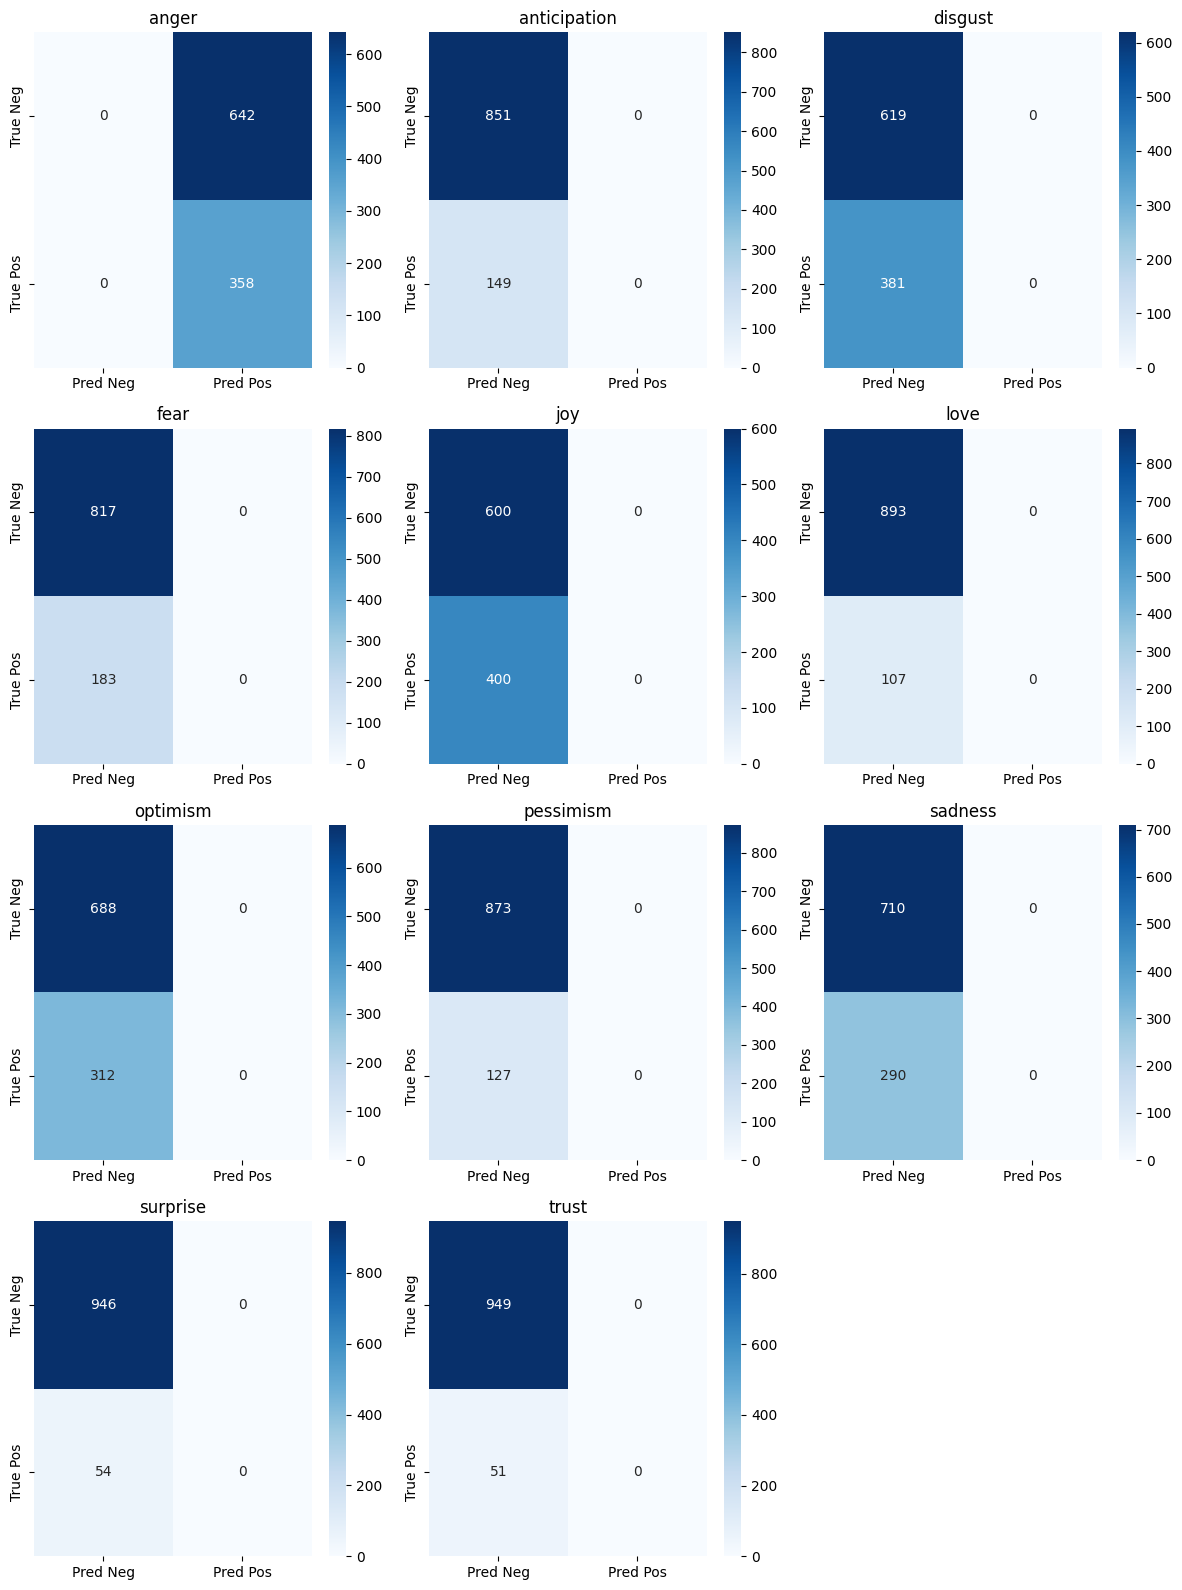

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


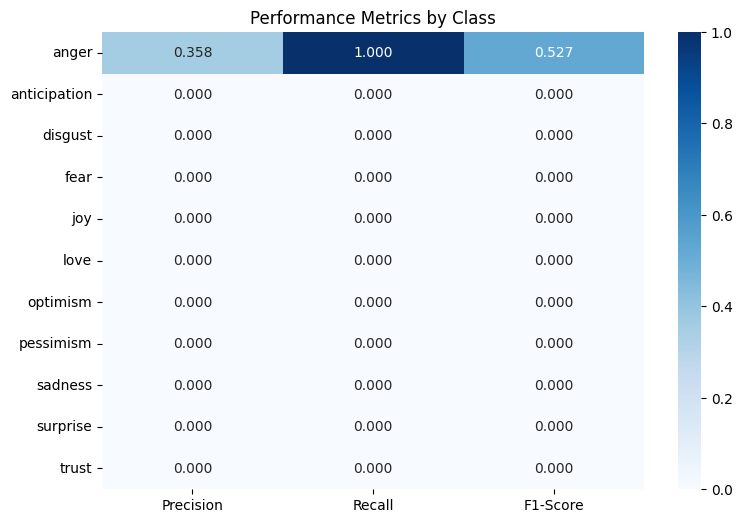

<Figure size 1200x533.333 with 0 Axes>

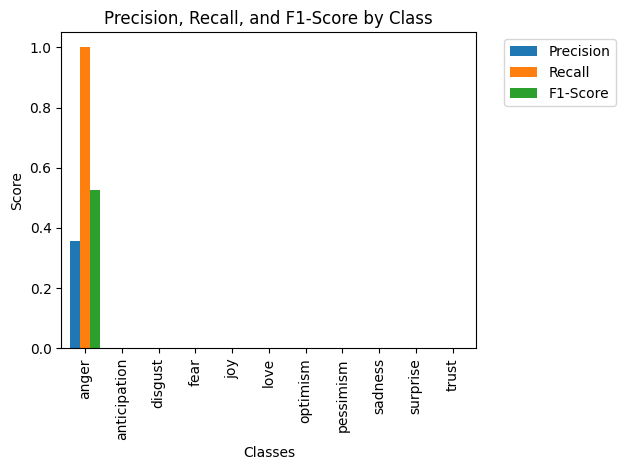

{'macro_avg': {'precision': 0.032545454545454544,
  'recall': 0.09090909090909091,
  'f1': 0.04793144999330567},
 'per_class': {'Precision': {'anger': 0.358,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 1.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.5272459499263623,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0}}}

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 100.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
sample = test_df['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.5063275694847107},
  {'label': 'anticipation', 'score': 0.12258714437484741},
  {'label': 'disgust', 'score': 0.4798482358455658},
  {'label': 'fear', 'score': 0.10702770203351974},
  {'label': 'joy', 'score': 0.4726220667362213},
  {'label': 'love', 'score': 0.14656716585159302},
  {'label': 'optimism', 'score': 0.3029026985168457},
  {'label': 'pessimism', 'score': 0.07019499689340591},
  {'label': 'sadness', 'score': 0.2425861358642578},
  {'label': 'surprise', 'score': 0.029701467603445053},
  {'label': 'trust', 'score': 0.05737617611885071}]]

In [ ]:
def get_labels(pipeline_output, threshold = 0.4):

  positive_labels = []

  for pred_set in pipeline_output:

    # getting the labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>=threshold]

    positive_labels.append(sample_positives)

  return positive_labels

In [ ]:
results = get_labels(preds, threshold = 0.4)
results

[['anger', 'disgust', 'joy']]

## <font color = 'pickle'>**Final Inferencing**

- To make my final predictions and upload for Kaggle I am going to write a function that takes some prior logic I used in my last notebook to append the labels for each id.
- I will then export a csv to submit to the Kaggle Competition
- After that step I will be writing a report to represent some challenges I  had while working with this extremely imbalanced dataset even when using the RoBERTa model.


In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, threshold = 0.4):
  """
  This function will process the pipeline output, apply the threshold and get predictions for the test dataset
  and generate a final DataFrame containing the test ID's and predicted labels.

  Parameters:
  - pipeline_output: The output from the custom pipeline (containing the scores)
  - model: The model used for generating the pipeline output (to get the id2labels)
  - df_test_ids: A dataframe containing the test ID's
  - threshold: The prediction threshold for making a prediction (default is 0.4)

  Returns:
  - df_pred_final: A pandas dataframe with the test ID's and their corresponding label predictions in binary format
  - positive_labels_list: a list of positive labels for each instance to compare results.
  """

  # 1. Prepare lists for appending results
  positive_labels_list = []
  binary_predictions = []

  # 2. Process the lists to store the binary preditions and positive labels

  for pred_set in pipeline_output:
    # Getting the positive labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>= threshold]
    positive_labels_list.append(sample_positives)

    # Getting the binary predictions ( 1 if >= threshold, else 0)
    binary_preds = [1 if pred['score'] >= threshold else 0 for pred in pred_set]
    binary_predictions.append(binary_preds)

  # 3. Convert the binary predictions to a dataframe
  # Map the model config labels
  class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]

  df_predictions = pd.DataFrame(binary_predictions, columns = class_labels)

  df_pred_final = pd.concat([df_test_ids.reset_index(drop = True), df_predictions], axis = 1 )


  return df_pred_final, positive_labels_list



In [ ]:
df_test_ids = joblib.load(data_folder/'test_ids.pkl')
df_test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'pickle'>**Here I am prepping the test_df to make predictions**

In [ ]:
test_ds = test_df.drop(columns = {'label'})

In [ ]:
test_ds = Dataset.from_pandas(test_ds)

<font color = 'pickle'>**Three Sequences to test output from the pipeline**


In [ ]:
test_ds['text'][0:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
pipeline_output = custom_pipeline(test_ds['text'][:])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Making predictions and getting the dataset for submission
df_pred_final, positive_label_list = get_predictions_from_pipeline(pipeline_output,
                                                                   model = model,
                                                                   df_test_ids = df_test_ids,
                                                                   threshold = 0.4)

In [ ]:
df_pred_final = df_pred_final.set_index('ID')

In [ ]:
df_pred_final.sum()

,0
ID,2018-015592018-037392018-003852018-030012018-0...
anger,3259
anticipation,0
disgust,3259
fear,0
joy,3259
love,0
optimism,0
pessimism,0
sadness,0


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_roberta.csv')

# <font color = 'indianred'>**Debugging**

<font color = 'pickle'>**Here I noticed that the scores output by the model were the same for each sequence**

- Based on this I decided to try using the model against two very different sequences to see if it was doing it for every sequence.

In [ ]:
result = pipeline_output[0:3]
result

[[{'label': 'anger', 'score': 0.5063275694847107},
  {'label': 'anticipation', 'score': 0.12258714437484741},
  {'label': 'disgust', 'score': 0.4798482358455658},
  {'label': 'fear', 'score': 0.10702770203351974},
  {'label': 'joy', 'score': 0.4726220667362213},
  {'label': 'love', 'score': 0.14656716585159302},
  {'label': 'optimism', 'score': 0.3029026985168457},
  {'label': 'pessimism', 'score': 0.07019499689340591},
  {'label': 'sadness', 'score': 0.2425861358642578},
  {'label': 'surprise', 'score': 0.029701467603445053},
  {'label': 'trust', 'score': 0.05737617611885071}],
 [{'label': 'anger', 'score': 0.5063275694847107},
  {'label': 'anticipation', 'score': 0.12258714437484741},
  {'label': 'disgust', 'score': 0.4798482358455658},
  {'label': 'fear', 'score': 0.10702770203351974},
  {'label': 'joy', 'score': 0.4726220667362213},
  {'label': 'love', 'score': 0.14656716585159302},
  {'label': 'optimism', 'score': 0.3029026985168457},
  {'label': 'pessimism', 'score': 0.0701949968

<font color = 'pickle'>**Here I tried to use padding and tensors to make the predictions and see if that made a difference in the scoring**

In [ ]:
# Check if the model is on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Manually tokenize the first few text samples with padding and truncation
inputs = custom_pipeline.tokenizer(test_ds['text'][0:3],
                                   padding=True,  # Add padding to ensure all sequences have the same length
                                   truncation=True,  # Truncate sequences that are too long
                                   return_tensors="pt")  # Return PyTorch tensors

# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Print the input IDs to check the tokenization with padding
print(inputs['input_ids'])

# Run the tokenized inputs through the model
with torch.no_grad():
    outputs = custom_pipeline.model(**inputs)

# Convert logits to probabilities using sigmoid (for multilabel classification)
probabilities = torch.sigmoid(outputs.logits)

# Print the probabilities for each class
print(probabilities)


tensor([[    0,  1039,  9167, 10197, 30529, 38925, 30529,   787,  1620,  1185,
          7199,   771,  1173,   211,  2533,  4022,  1362,  3835,    16,    15,
            63,  1319,     7, 22903,    70, 23877,  1952,     7, 11141,     2],
        [    0, 26145,   625, 27171,     9,  8841,     6, 33404, 12240,     5,
          6329, 17333,  6328,     9,  6441,  6665,     8,  1519,     5,  2232,
           872,     9,  7892,    10,    44,    48,  5605,  9779, 43029,     2],
        [    0,   100, 10879,    14,   945,   111, 30529,    12,   849, 17497,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]],
       device='cuda:0')
tensor([[0.5063, 0.1226, 0.4798, 0.1070, 0.4726, 0.1466, 0.3029, 0.0702, 0.2426,
         0.0297, 0.0574],
        [0.5063, 0.1226, 0.4798, 0.1070, 0.4726, 0.1466, 0.3029, 0.0702, 0.2426,
         0.0297, 0.0574],
        [0.5063, 0.1226, 0.4798, 0.1070, 0.4726

<font color = 'pickle'>**Again the same scores were calculated**

In [ ]:
# Example of testing with very different inputs
new_texts = ["This is a very different sentence.", "Another completely different sentence about technology."]
new_inputs = custom_pipeline.tokenizer(new_texts, padding=True, truncation=True, return_tensors="pt").to(device)

# Run through the model
with torch.no_grad():
    outputs = custom_pipeline.model(**new_inputs)
    probabilities = torch.sigmoid(outputs.logits)

print(probabilities)

tensor([[0.5063, 0.1226, 0.4798, 0.1070, 0.4726, 0.1466, 0.3029, 0.0702, 0.2426,
         0.0297, 0.0574],
        [0.5063, 0.1226, 0.4798, 0.1070, 0.4726, 0.1466, 0.3029, 0.0702, 0.2426,
         0.0297, 0.0574]], device='cuda:0')
